# EE236A Project
- Author: Jenny Chen
- Fall 2025
- We are analyzing the paper: 
    - Q. Guo, R. Sekine, L. Ledezma, R. Nehra, D. J. Dean, A. Roy, R. M. Gray, S. Jahani, A. Marandi, et al., “Femto-joule femtosecond all-optical switching in lithium niobate nanophotonics”, Nature Photonics 16, 625–631 (2022)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.constants import *
import pandas as pd
from scipy.special import ellipj

blue = "#3a64da"
red = "#df4545"

# Process Simulation
- To solve the second harmonic generation (SHG) and degenerate optical parametric amplification equations exactly, we heavily reference the following paper to perform our analyses. 
    - J. A. Armstrong, N. Bloembergen, J. Ducuing, and P. S. Pershan, “Interactions between light waves in a nonlinear dielectric”, Phys. Rev. 127, 1918–1939 (1962).
    - https://journals.aps.org/pr/pdf/10.1103/PhysRev.127.1918
- The following equations depicted here are taken from Armstrong et al.'s paper

Coupled wave equations: <br>
<img src="img\image-3.png" width="400"> <br> <br>
Variables are substitued with: <br>
<img src="img\image.png" width="400"> <br> <br>
New equations: <br>
<img src="img\image-2.png" width="400">


## 1. Second Harmonic Generation (SHG)

- deff derives from https://covesion.com/knowledge-hub/technical-guide-material-properties-of-lithium-niobate/
- $n_{e, 2090}$ derives from https://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-e

In [34]:
# Declare parameters
wavelength = 2090e-9
ne_2090 = 2.1229

k1 = 2 * np.pi / wavelength
k2 = 2 * np.pi / (wavelength / 2)
omega = c * k1

deff = 15e-12  # m/V,  d33 for LN
chi_omega1 = deff / (2 * np.pi)
K = 2 * np.pi * chi_omega1 / c**2 
print(f"K = {K : .3e}")

pulse_energy = 100e-15 # Joules, paper
pulse_duration = 46e-15  # seconds, paper
area = 8e-12  # m^2, estimated
rho1_0 = np.sqrt(pulse_energy / (area * pulse_duration * 2 * ne_2090 * c * epsilon_0))
print(f"rho1_0 = {rho1_0 :.3e}")

rho2_0 = 0
alpha1 = 0
alpha2 = 0
phi1_0 = 0
phi2_0 = 0

total_length = 6e-3
shg_length = 2.5e-3
total_points = 5000
shg_points = int(shg_length / total_length * total_points)
dopa_points = total_points - shg_points

K =  1.669e-28
rho1_0 = 4.910e+06


In [35]:
W = (c**2 / (8 * np.pi * omega)) * (k1 * rho1_0**2 * (np.cos(alpha1))**2 + 0.5 * k2 * rho2_0**2 * (np.cos(alpha2))**2)
print(f"W = {W : .3e}")

delta_k = 2*np.pi * 0.05e-9 / wavelength**2  # paper
print(f"Delta k = {delta_k : .3f}")

delta_s = delta_k / ((2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
                     (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2))
print(f"Delta s = {delta_s : .5f}")

W =  2.876e+20
Delta k =  71.921
Delta s =  0.16240


Important for derivation: <br>
<img src="img\image-4.png" width="400"> <br><br>

Solve for the roots $v_a$, $v_b$, and $v_c$: <br>
<img src="img\image-5.png" width="400">

Obtain the field amplitudes: <br>
<img src="img\image-6.png" width="400"> <br><br>

Requires using the Jacobian elliptic equations

In [36]:
# Get gamma T
Tau = (2 * k1 / k2) * (c**2 * k2 / (16 * np.pi * omega * W)**(3/2) * rho1_0 * rho2_0) * (np.cos(alpha1))**2 * np.cos(alpha2) * np.cos(phi2_0 - 2 * phi1_0)

# Get roots
x_0 = 0  # because rho2 = 0

coeff_3 = 1
coeff_2 = -2 - 0.25 * delta_s**2
coeff_1 = 1 + Tau * delta_s + 0.5 * delta_s**2 * x_0
coeff_0 = -Tau**2 - Tau * delta_s * x_0 - 0.25 * delta_s**2 * x_0**2
cubic_coeff = [coeff_3, coeff_2, coeff_1, coeff_0]
roots = np.sort(np.roots(cubic_coeff))[::-1]
vc, vb, va = roots
print(f"vc^2, vb^2, va^2 = {roots}")

# Evalute u^2 and v^2
gamma_2 = (vb - va) / (vc - va)
gamma = np.sqrt(gamma_2)

shg_zs = np.linspace(0, shg_length, shg_points)
zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
    (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * shg_zs
zeta_0 = 0
shg_v_2 = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
shg_u_2 = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

vc^2, vb^2, va^2 = [1.08456459 0.92202899 0.        ]


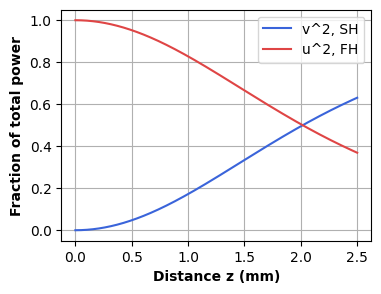

In [37]:
# Plot for different z and amplitudes
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(shg_zs*1e3, shg_v_2, label="v^2, SH", color=blue)
ax.plot(shg_zs*1e3, shg_u_2, label="u^2, FH", color=red)
ax.legend()
ax.set_xlabel("Distance z (mm)")
ax.set_ylabel("Fraction of total power")
ax.grid()
plt.show()

## 2. Linear Directional Coupler

In [38]:
# Decrease the amplitudes proportionally according to the directional coupler in the paper
fh_ratio = 0.15
sh_ratio = 0.95

u_2_SHG = shg_u_2[-1] * fh_ratio
v_2_SHG = shg_v_2[-1] * sh_ratio

## 3. Degenerate Optical Parametric Amplification
- Difference frequency generation
- Second harmonic --> Fundamental harmonic
- Same equations as 1. 

In [39]:
rho1_0_dopa = rho1_0 * u_2_SHG
rho2_0_dopa = rho1_0 * v_2_SHG
print(f"Rho1_0 = {rho1_0_dopa : .3e}")
print(f"Rho2_0 = {rho2_0_dopa : .3e}")

alpha1 = 0
alpha2 = 0
phi1_0 = 0
phi2_0 = 0

# constant_of_integ = 
W = (c**2 / (8 * np.pi * omega)) * (k1 * rho1_0_dopa**2 * (np.cos(alpha1))**2 +\
                                     0.5 * k2 * rho2_0_dopa**2 * (np.cos(alpha2))**2)
print(f"W = {W : .3e}")

# Use final states
x_0 = ((c**2 * k2 * (np.cos(alpha2))**2 / (16 * np.pi * omega * W)) **(1/2) * rho2_0_dopa)**2

delta_s = delta_k / ((2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
                     (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2))
print(f"Delta s = {delta_s : .3e}")

# Get gamma T
Tau = (2 * k1 / k2) * ((c**2 * k2 / (16 * np.pi * omega * W))**(3/2) * rho1_0_dopa**2 * rho2_0_dopa) *\
      (np.cos(alpha1))**2 * np.cos(alpha2) * np.cos(phi2_0 - 2 * phi1_0)
print(f"Tau = {Tau : .3e}")


Rho1_0 =  2.718e+05
Rho2_0 =  2.943e+06
W =  1.042e+20
Delta s =  2.698e-01
Tau =  8.422e-03


Roots = [1.00639762 0.99154213 0.0202576 ]
0.08454927609686348 0.9154507239031365
[3624  728 2168 2169 3625]


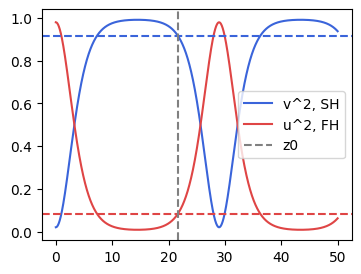

In [40]:
# Get roots
coeff_3 = 1
coeff_2 = -2 - 0.25 * delta_s**2
coeff_1 = 1 + Tau * delta_s + 0.5 * delta_s**2 * x_0
coeff_0 = -Tau**2 - Tau * delta_s * x_0 - 0.25 * delta_s**2 * x_0**2
cubic_coeff = [coeff_3, coeff_2, coeff_1, coeff_0]
roots = np.sort(np.roots(cubic_coeff))[::-1]
vc, vb, va = roots
print(f"Roots = {roots}")

# Evalute u^2 and v^2
gamma_2 = (vb - va) / (vc - va)
gamma = np.sqrt(gamma_2)

zs = np.linspace(0, 50e-3, 5000)
zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
    (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * zs
zeta_0 = 0

v_2_dopa = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
u_2_dopa = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

# Find zeta_0
u_dopa_cond = u_2_SHG / (u_2_SHG + v_2_SHG)
v_dopa_cond = v_2_SHG / (u_2_SHG + v_2_SHG)
print(u_dopa_cond, v_dopa_cond)

err = np.sqrt((u_2_dopa -  u_dopa_cond)**2 + (v_2_dopa - v_dopa_cond)**2)
errs = np.sort(err)
sorted_indices = np.argsort(err)
print(sorted_indices[:5])
z_i = sorted_indices[3]
z_0_new = zs[z_i]

# Plot for different z and amplitudes
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(zs*1e3, v_2_dopa, label="v^2, SH", color=blue)
ax.plot(zs*1e3, u_2_dopa, label="u^2, FH", color=red)

ax.axhline(v_dopa_cond, color=blue, linestyle="--")
ax.axhline(u_dopa_cond, color=red, linestyle="--")
ax.axvline(z_0_new*1e3, color="gray", linestyle="--", label="z0")

plt.legend()
plt.show()

In [41]:
dopa_zs = np.linspace(z_0_new, z_0_new + (total_length - shg_length), dopa_points)
zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
    (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * dopa_zs
zeta_0 = 0

v_2_dopa = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
u_2_dopa = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

v_2_dopa *= (u_2_SHG + v_2_SHG)
u_2_dopa *= (u_2_SHG + v_2_SHG)

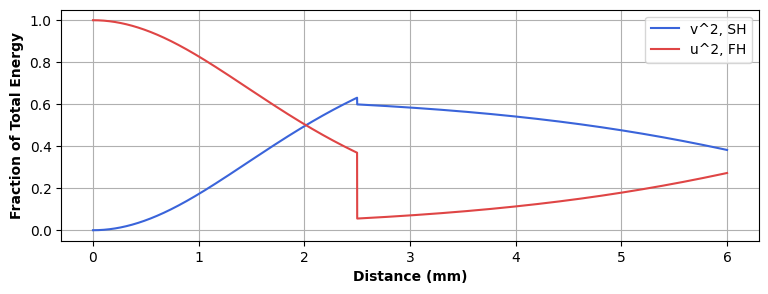

In [42]:
# Plot everything
zs = np.linspace(0, total_length, total_points)
u_2 = np.concatenate((shg_u_2, u_2_dopa))
v_2 = np.concatenate((shg_v_2, v_2_dopa))

# Plot for different z and amplitudes
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(zs*1e3, v_2, label="v^2, SH", color=blue)
ax.plot(zs*1e3, u_2, label="u^2, FH", color=red)

ax.set_xlabel("Distance (mm)")
ax.set_ylabel("Fraction of Total Energy")

ax.grid()
plt.legend()
plt.show()

# Application

- Obtaining the optimal relative lengths of the SHG and DOPA regions in the waveguide

In [43]:
def get_amplitudes(pulse_energy, pulse_duration, shg_length, total_length, delta_k, area=1e-12, plot=False):

    # Declare parameters
    wavelength = 2090e-9
    ne_2090 = 2.124
    k1 = 2 * np.pi / wavelength
    k2 = 2 * np.pi / (wavelength / 2)
    omega = c * k1

    deff = 15e-12  # m/V,  d33 for LN
    chi_omega1 = deff / (2 * np.pi)
    K = 2 * np.pi * chi_omega1 / c**2 

    # area = 1e-12  # m^2, estimated
    rho1_0 = np.sqrt(pulse_energy / (area * pulse_duration * 2 * ne_2090 * c * epsilon_0))
    rho2_0 = 0
    alpha1 = 0
    alpha2 = 0
    phi1_0 = 0
    phi2_0 = 0

    total_points = 5000
    shg_points = int(shg_length / total_length * total_points)
    dopa_points = total_points - shg_points

    W = (c**2 / (8 * np.pi * omega)) * (k1 * rho1_0**2 * (np.cos(alpha1))**2 + 0.5 * k2 * rho2_0**2 * (np.cos(alpha2))**2)
    # delta_k = 0.1  # paper
    delta_s = delta_k / ((2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
                        (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2))
    # print(f"Delta_s = {delta_s : .3e}")
    # Get gamma T
    Tau = (2 * k1 / k2) * (c**2 * k2 / (16 * np.pi * omega * W)**(3/2) * rho1_0 * rho2_0) * (np.cos(alpha1))**2 * np.cos(alpha2) * np.cos(phi2_0 - 2 * phi1_0)

    # Get roots
    x_0 = 0  # because rho2 = 0
    coeff_3 = 1
    coeff_2 = -2 - 0.25 * delta_s**2
    coeff_1 = 1 + Tau * delta_s + 0.5 * delta_s**2 * x_0
    coeff_0 = -Tau**2 - Tau * delta_s * x_0 - 0.25 * delta_s**2 * x_0**2
    cubic_coeff = [coeff_3, coeff_2, coeff_1, coeff_0]
    roots = np.sort(np.roots(cubic_coeff))[::-1]
    vc, vb, va = roots
    # print(f"vc^2, vb^2, va^2 = {roots}")

    # Evalute u^2 and v^2
    gamma_2 = (vb - va) / (vc - va)
    gamma = np.sqrt(gamma_2)

    shg_zs = np.linspace(0, shg_length, shg_points)
    zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
        (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * shg_zs
    zeta_0 = 0
    shg_v_2 = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
    shg_u_2 = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

    # Decrease the amplitudes proportionally according to the directional coupler in the paper
    fh_ratio = 0.15
    sh_ratio = 0.95

    u_2_SHG = shg_u_2[-1] * fh_ratio
    v_2_SHG = shg_v_2[-1] * sh_ratio

    rho1_0_dopa = rho1_0 * u_2_SHG
    rho2_0_dopa = rho1_0 * v_2_SHG

    alpha1 = 0
    alpha2 = 0
    phi1_0 = 0
    phi2_0 = 0

    W = (c**2 / (8 * np.pi * omega)) * (k1 * rho1_0_dopa**2 * (np.cos(alpha1))**2 +\
                                        0.5 * k2 * rho2_0_dopa**2 * (np.cos(alpha2))**2)
    # Use final states
    x_0 = ((c**2 * k2 * (np.cos(alpha2))**2 / (16 * np.pi * omega * W)) **(1/2) * rho2_0_dopa)**2
    delta_s = delta_k / ((2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
                        (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2))

    # Get gamma T
    Tau = (2 * k1 / k2) * ((c**2 * k2 / (16 * np.pi * omega * W))**(3/2) * rho1_0_dopa**2 * rho2_0_dopa) *\
        (np.cos(alpha1))**2 * np.cos(alpha2) * np.cos(phi2_0 - 2 * phi1_0)
    
    # Get roots
    coeff_3 = 1
    coeff_2 = -2 - 0.25 * delta_s**2
    coeff_1 = 1 + Tau * delta_s + 0.5 * delta_s**2 * x_0
    coeff_0 = -Tau**2 - Tau * delta_s * x_0 - 0.25 * delta_s**2 * x_0**2
    cubic_coeff = [coeff_3, coeff_2, coeff_1, coeff_0]
    roots = np.sort(np.roots(cubic_coeff))[::-1]
    vc, vb, va = roots
    print(f"vc^2, vb^2, va^2 = {roots}")

    # Evalute u^2 and v^2
    gamma_2 = (vb - va) / (vc - va)
    gamma = np.sqrt(gamma_2)

    zs = np.linspace(0, 50e-3, 5000)
    zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
        (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * zs
    zeta_0 = 0

    v_2_dopa = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
    u_2_dopa = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

    # Find zeta_0
    u_dopa_cond = u_2_SHG / (u_2_SHG + v_2_SHG)
    v_dopa_cond = v_2_SHG / (u_2_SHG + v_2_SHG)

    err = np.sqrt((u_2_dopa -  u_dopa_cond)**2 + (v_2_dopa - v_dopa_cond)**2)
    sorted_indices = np.argsort(err)
    z_i = 0
    z_0_new = 0
    for i in range(5):
        z_i = sorted_indices[i]
        if z_i < len(zs)-1:
            if v_2_dopa[z_i+1] - v_2_dopa[z_i] < 0:
                z_0_new = zs[z_i]
        else: 
            if v_2_dopa[z_i] - v_2_dopa[z_i-1] < 0:
                z_0_new = zs[z_i]

    # Combine the two datasets
    dopa_zs = np.linspace(z_0_new, z_0_new + (total_length - shg_length), dopa_points)
    zetas = (2 * omega**2 * K / (k1 * (np.cos(alpha1))**2)) * \
        (16 * np.pi * omega * W / (c**2 * k2 * (np.cos(alpha2))**2))**(1/2) * dopa_zs
    zeta_0 = 0

    v_2_dopa = va + (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2
    u_2_dopa = 1 - va - (vb - va) * (ellipj((vc - va)**(1/2) * (zetas + zeta_0), gamma)[0])**2

    v_2_dopa *= (u_2_SHG + v_2_SHG)
    u_2_dopa *= (u_2_SHG + v_2_SHG)

    # Plot everything
    zs = np.linspace(0, total_length, total_points)
    u_2 = np.concatenate((shg_u_2, u_2_dopa))
    v_2 = np.concatenate((shg_v_2, v_2_dopa))

    return u_2, v_2

vc^2, vb^2, va^2 = [1.00090556e+00 9.99067075e-01 2.35426851e-04]


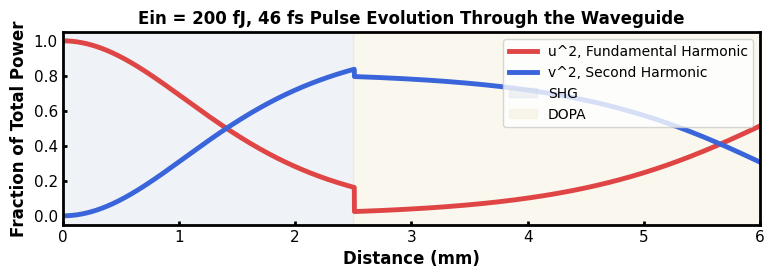

In [44]:
pulse_energy = 200e-15
delta_k = 2*np.pi*0.01e-9/(2.09e-6)**2
u2_25, v2_25 = get_amplitudes(
    pulse_energy=pulse_energy,
    pulse_duration=46e-15,
    shg_length=2.51e-3,
    total_length=6e-3,
    delta_k=delta_k,
    area=8e-12,
    plot=True
)

# Plot for different z and amplitudes
plt.rcParams["axes.labelweight"] = "bold" # also set the axes label weight
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.plot(zs*1e3, u2_25, label="u^2, Fundamental Harmonic", color=red, linewidth=3.5)
ax.plot(zs*1e3, v2_25, label="v^2, Second Harmonic", color=blue, linewidth=3.5)
ax.axvspan(0, 2.5, color="#d2dce9", alpha=0.35, label='SHG') 
ax.axvspan(2.5, 6, color="#f0e9cf", alpha=0.35, label='DOPA') 
ax.tick_params(axis='both', which='major', width=2, length=3, direction='in', labelsize=11) 
ax.set_xlim(0, 6)
ax.set_xlabel("Distance (mm)", fontsize=12)
ax.set_ylabel("Fraction of Total Power", fontsize=12)
ax.set_title(f"Ein = {pulse_energy*1e15:.0f} fJ, 46 fs Pulse Evolution Through the Waveguide", fontweight="bold")
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.legend(loc = 'upper right')
plt.savefig("power_evolution_higherres.png", dpi=300, bbox_inches='tight')
plt.show()

vc^2, vb^2, va^2 = [1.05650024 0.93049148 0.01808114]


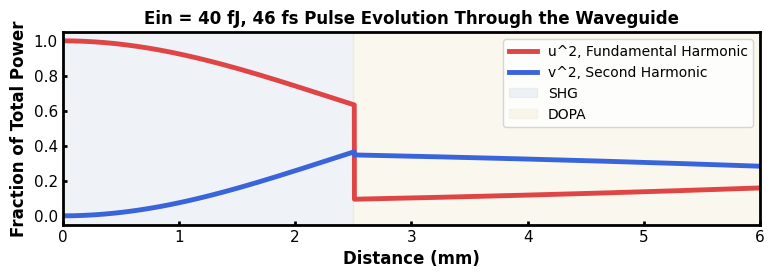

In [45]:
pulse_energy = 40e-15
delta_k = 2*np.pi*0.01e-9/(2.09e-6)**2
u2_25, v2_25 = get_amplitudes(
    pulse_energy=pulse_energy,
    pulse_duration=46e-15,
    shg_length=2.51e-3,
    total_length=6e-3,
    delta_k=delta_k,
    area=8e-12,
    plot=True
)

# Plot for different z and amplitudes
# plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold" # also set the axes label weight
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.plot(zs*1e3, u2_25, label="u^2, Fundamental Harmonic", color=red, linewidth=3.5)
ax.plot(zs*1e3, v2_25, label="v^2, Second Harmonic", color=blue, linewidth=3.5)
ax.axvspan(0, 2.5, color="#d2dce9", alpha=0.35, label='SHG') 
ax.axvspan(2.5, 6, color="#f0e9cf", alpha=0.35, label='DOPA') 
ax.tick_params(axis='both', which='major', width=2, length=3, direction='in', labelsize=11) 
ax.set_xlim(0, 6)
ax.set_xlabel("Distance (mm)", fontsize=12)
ax.set_ylabel("Fraction of Total Power", fontsize=12)
ax.set_title(f"Ein = {pulse_energy*1e15:.0f} fJ, 46 fs Pulse Evolution Through the Waveguide", fontweight="bold")
for spine in ax.spines.values():
    spine.set_linewidth(2)
# ax.grid()
plt.legend(loc = 'upper right')
plt.savefig("power_evolution_40fJ.png", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
shg_lengths = np.linspace(1.5, 4.5, 200) * 1e-3
contrasts = np.zeros(len(shg_lengths))

u_2_fh_low = np.zeros(len(shg_lengths))
u_2_fh_high = np.zeros(len(shg_lengths))

for l in range(len(shg_lengths)):
    u_2_orig, v_2_orig = get_amplitudes(
        pulse_energy=40e-15,
        pulse_duration=46e-15,
        shg_length=shg_lengths[l],
        total_length=6e-3,
        delta_k=delta_k,
        area=8e-12,
        plot=False
    )

    u_2_double, v_2_double = get_amplitudes(
        pulse_energy=80e-15,
        pulse_duration=46e-15,
        shg_length=shg_lengths[l],
        total_length=6e-3,
        delta_k=delta_k,
        area=8e-12,
        plot=False
    )

    contrast = 2 * u_2_double[-1] / u_2_orig[-1]
    contrasts[l] = contrast
    u_2_fh_low[l] = u_2_orig[-1]
    u_2_fh_high[l] = u_2_double[-1]

vc^2, vb^2, va^2 = [1.21383911 0.58308865 0.22028741]
vc^2, vb^2, va^2 = [1.10687934 0.86242138 0.03462605]
vc^2, vb^2, va^2 = [1.21156104 0.59332796 0.21201645]
vc^2, vb^2, va^2 = [1.10349276 0.86761907 0.03271494]
vc^2, vb^2, va^2 = [1.20918653 0.60339727 0.20401507]
vc^2, vb^2, va^2 = [1.10019966 0.87261007 0.03092025]
vc^2, vb^2, va^2 = [1.20672371 0.61329284 0.19627907]
vc^2, vb^2, va^2 = [1.09699932 0.87740226 0.02923473]
vc^2, vb^2, va^2 = [1.20418052 0.62301145 0.18880392]
vc^2, vb^2, va^2 = [1.09389079 0.88200331 0.02765158]
vc^2, vb^2, va^2 = [1.20156464 0.63255041 0.18158478]
vc^2, vb^2, va^2 = [1.09087294 0.88642067 0.02616437]
vc^2, vb^2, va^2 = [1.19888353 0.64190753 0.17461653]
vc^2, vb^2, va^2 = [1.08794446 0.89066158 0.02476708]
vc^2, vb^2, va^2 = [1.19614439 0.65108109 0.16789382]
vc^2, vb^2, va^2 = [1.08510392 0.89473303 0.02345405]
vc^2, vb^2, va^2 = [1.19335414 0.66006983 0.16141111]
vc^2, vb^2, va^2 = [1.08234977 0.8986418  0.02221997]
vc^2, vb^2, va^2 = [1.190519

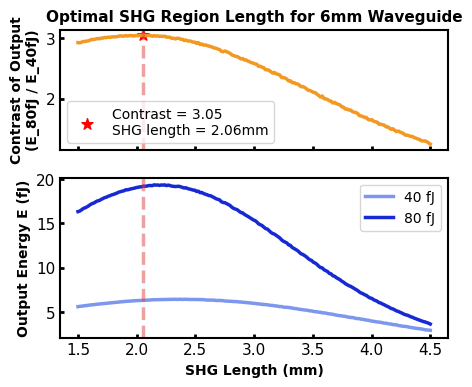

In [47]:
max_contrast = np.max(contrasts[:-10])
contrast_i = np.argmax(contrasts[:-10])

fig, ax = plt.subplots(2, 1, figsize=(5, 4), sharex=True, gridspec_kw={'height_ratios': [1.5, 2]})
ax[0].plot(shg_lengths*1e3, contrasts, color="#f39821", linewidth=2.5)
ax[0].set_ylabel("Contrast of Output\n(E_80fJ / E_40fJ)")
ax[0].scatter(shg_lengths[contrast_i]*1e3, max_contrast, marker="*", color="red", s=70, label=f"Contrast = {max_contrast:.2f}\nSHG length = {shg_lengths[contrast_i]*1e3:.2f}mm")
ax[0].axvline(shg_lengths[contrast_i]*1e3, linestyle="--", color=red, alpha=0.5, linewidth=2.5)
ax[0].legend()

ax[1].set_xlabel("SHG Length (mm)")
ax[1].plot(shg_lengths*1e3, u_2_fh_low*40, label="40 fJ", color="#7D97EE", linewidth=2.5)
ax[1].plot(shg_lengths*1e3, u_2_fh_high*80, label="80 fJ", color="#1729d3", linewidth=2.5)
ax[1].legend()
ax[1].set_ylabel("Output Energy E (fJ)")
ax[1].axvline(shg_lengths[contrast_i]*1e3, linestyle="--", color=red, alpha=0.5, linewidth=2.5)

ax[0].set_title("Optimal SHG Region Length for 6mm Waveguide", fontsize=11, fontweight="bold")
ax[0].tick_params(axis='both', which='major', width=2, length=3, direction='in', labelsize=11) 
ax[1].tick_params(axis='both', which='major', width=2, length=3, direction='in', labelsize=11) 

for spine in ax[0].spines.values():
    spine.set_linewidth(1.5)
for spine in ax[1].spines.values():
    spine.set_linewidth(1.5)
plt.savefig("optimal_length_bold.png", dpi=300, bbox_inches='tight')

plt.show()